In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

import matplotlib.pyplot as plt
import mlai.plot as plot

In [169]:
# Simulation presettings
write_images = False
wirte_output_txt = False
%run Missile_utils.ipynb
simulation_output = 'range'

In [19]:
custom_param_names = ['fuelmass']

In [20]:
# Low-fidelity simulator class
class simple_simulator_mod:
    def __init__(self,fuelmass,drymass,payload,missilediam,params=True):
        self.dMdt = 1.4e4
        self.v_ex = 2000
        
        if params is None:
            self.drymass = 0.8e6
            self.fuelmass = 2e6
            self.diam = 1.65
            
        else:
            self.drymass = drymass + payload
            self.fuelmass = fuelmass
            self.diam = missilediam
    
    def get_range(self):
        h=1e-5
        v=1e-5
        gamma = self.to_radians(90)
        thrust = self.v_ex * self.dMdt
        mass = self.drymass + self.fuelmass
        area = pi*(self.diam**2)/4
        G = 6.6743e-11
        M = 5.972e24
        R = 6.371e6
        g = G*M/(R**2)
        dm = self.dMdt
        t=0
        psi=0
        dt=1e-1
        tEND=1e3
        heights = []
        gammas = []
        while(h>0):
            if t>tEND:
                break
            try:
                dv = thrust/mass - g*sin(gamma)
            except:
                dv = 0
            dpsi = v*cos(gamma)/(R+h)
            dh = v*sin(gamma)
            if t<5:
                dgamma = 0
            elif t>5 and gamma==self.to_radians(90):
                gamma = gamma-0.0001
            else:
                dgamma = dpsi - g*cos(gamma)/v
                
            if mass == self.drymass:
                thrust=0
                dm=0
            else:
                mass = mass - dm*dt
                
            v = v + dt*dv
            h = h + dt*dh
            heights.append(h)
            gamma = gamma + dt*dgamma
            gammas.append(gamma)
            psi = psi + dt*dpsi
            g =  G*M/((R+h)**2)
            t= t+dt
            
        #plt.plot(heights)
        #plt.show()
        #plt.plot(gammas)
        #plt.show()
        if psi<0:
            print("Rocket Failed (PSI)")
            return 0
        if t>tEND:
            print("Rocket Failed (tend)")
            return 0
        return psi*R/1000
        
        
    def eta(self,h,t):
        eta = 0.0
        return eta      
    
    def density(self,h):
        "Calculates air density at altitude"    
        rho0 = 1.225 #[kg/m^3] air density at sea level
        if h < 19200:
            rho = rho0 * exp(-h/8420)
        elif h > 19200 and h < 47000:
            rho = rho0 * (.857003 + h/57947)**-13.201
        else:
            #vacuum
            rho = 0.0
        return rho
        
    def temperature(self,h):
        "Calculates air temperature [Celsius] at altitude [m]"
        if h <= 11000:
            #troposphere
            t = 15.04 - .00649*h
        elif h <= 25000:
            #lower stratosphere
            t = -56.46
        elif h > 25000:
            t = -131.21 + .00299*h
        return t
    
    def pressure(self,h):
        "Calculates air pressure [Pa] at altitude [m]"  
        t = self.temperature(h)      
        if h <= 11000:
            #troposphere
            p = 101.29 * ((t+273.1)/288.08)**5.256
        elif h <= 25000:
            #lower stratosphere
            p = 22.65*exp(1.73-.000157*h)
        elif h > 25000:
            p = 2.488 * ((t+273.1)/288.08)**-11.388
        return p
        
    def Cdrag (self,v,h):
        t = self.temperature(h) + 273.15 #convert to kelvin
        a = sqrt(1.4*287*t) 
        mach = v/a
        
        if mach > 5:
            cd = 0.15
        elif mach > 1.8 and mach <= 5:
            cd = -0.03125*mach + 0.30625
        elif mach > 1.2 and mach <= 1.8:
            cd = -0.25*mach + 0.7
        elif mach > 0.8 and mach <= 1.2:
            cd = 0.625*mach - 0.35
        elif mach <= 0.8:
            cd = 0.15
        return cd
        
    def to_radians(self,degree):
        return degree * pi/180

In [21]:
# Low-fidelity simulation helper
def run_missile_low_sim(custom_params):
    """    
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'fuelmass':5600,
        'drymass':1200,
        'Isp0':226,
        'thrust0':9177.4
    }
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        # Row: different parameters -> different runs from the simulator
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            # For each custom variable
            param_name = custom_param_names[j]
            params_to_use[param_name] = custom_params[i,j]
        
            ## TEMP ## Better customise this
            #if j==0:
            #    print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            #print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_obj = simple_simulator_mod( 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"],
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],
        )
        Tm = 1.4e4*2000 / (params_to_use["fuelmass"]+params_to_use["drymass"])
        g = 6.6743e-11*5.972e24/(6.371e6**2)
        if Tm < g:
            print("Tm<g -> will fail")
        print(f'Fuel {params_to_use["fuelmass"]}, dry {params_to_use["drymass"]}')
        
        y[i, 0] = sim_obj.get_range()
    return y


In [22]:
# High-fidelity simulator helper
def run_missile_high_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }   
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


# Actual analysis-code starting; fuelmass

In [23]:
basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [24]:
high_f = run_missile_high_sim
low_f = run_missile_low_sim

x_dry = np.linspace(1200, 3000,101)[:, np.newaxis]
x_fuel = np.linspace(500, 6000, 101)[:, np.newaxis]
xt = np.array([x_fuel, x_dry]).reshape(101, 2)


x_plot = x_fuel
y_plot_low = low_f(x_fuel)
print(y_plot_low)


Fuel 500.0, dry 1200
Rocket Failed (PSI)
Fuel 555.0, dry 1200
Rocket Failed (PSI)
Fuel 610.0, dry 1200
Rocket Failed (PSI)
Fuel 665.0, dry 1200
Rocket Failed (PSI)
Fuel 720.0, dry 1200
Rocket Failed (PSI)
Fuel 775.0, dry 1200
Rocket Failed (PSI)
Fuel 830.0, dry 1200
Rocket Failed (PSI)
Fuel 885.0, dry 1200
Rocket Failed (PSI)
Fuel 940.0, dry 1200
Rocket Failed (PSI)
Fuel 995.0, dry 1200
Rocket Failed (PSI)
Fuel 1050.0, dry 1200
Rocket Failed (PSI)
Fuel 1105.0, dry 1200
Rocket Failed (tend)
Fuel 1160.0, dry 1200
Rocket Failed (tend)
Fuel 1215.0, dry 1200
Rocket Failed (tend)
Fuel 1270.0, dry 1200
Fuel 1325.0, dry 1200
Fuel 1380.0, dry 1200
Rocket Failed (PSI)
Fuel 1435.0, dry 1200
Rocket Failed (PSI)
Fuel 1490.0, dry 1200
Rocket Failed (PSI)
Fuel 1545.0, dry 1200
Rocket Failed (PSI)
Fuel 1600.0, dry 1200
Rocket Failed (PSI)
Fuel 1655.0, dry 1200
Rocket Failed (PSI)
Fuel 1710.0, dry 1200
Rocket Failed (PSI)
Fuel 1765.0, dry 1200
Rocket Failed (PSI)
Fuel 1820.0, dry 1200
Rocket Failed (PS

In [176]:
y_plot_high = high_f(x_dry)


New simulation 

drymass: 1200.0


Stage 1 burnout
Velocity (km/s):  2.037081299724615
Angle (deg h):  43.65219434294673
Range (km):  44.383061655570835
Time (sec):  137.89999999999645
Final results: 
Range (km):  546.8275659033618
Apogee (km):  173.37063815836208
Time to target (sec):  488.7000000000426



New simulation 

drymass: 1218.0


Stage 1 burnout
Velocity (km/s):  2.0178585300557894
Angle (deg h):  43.65219434294673
Range (km):  44.00982894330064
Time (sec):  137.89999999999645
Final results: 
Range (km):  537.2770744193534
Apogee (km):  170.66452361322092
Time to target (sec):  485.40000000004187



New simulation 

drymass: 1236.0


Stage 1 burnout
Velocity (km/s):  1.9989041789914155
Angle (deg h):  43.65219434294673
Range (km):  43.640379654044544
Time (sec):  137.89999999999645
Final results: 
Range (km):  527.8667837016274
Apogee (km):  168.01831143843197
Time to target (sec):  482.1000000000411



New simulation 

drymass: 1254.0


Stage 1 burnout
Velocity (km/s):  1

Final results: 
Range (km):  354.50923627789626
Apogee (km):  118.30864370877427
Time to target (sec):  416.8000000000263



New simulation 

drymass: 1686.0


Stage 1 burnout
Velocity (km/s):  1.5954832394029805
Angle (deg h):  43.65219434294673
Range (km):  35.455107697439885
Time (sec):  137.89999999999645
Final results: 
Range (km):  348.9378757470741
Apogee (km):  116.68661722931233
Time to target (sec):  414.50000000002575



New simulation 

drymass: 1704.0


Stage 1 burnout
Velocity (km/s):  1.5816914813593814
Angle (deg h):  43.65219434294673
Range (km):  35.1643784831678
Time (sec):  137.89999999999645
Final results: 
Range (km):  343.43890891059425
Apogee (km):  115.09269216381468
Time to target (sec):  412.2000000000252



New simulation 

drymass: 1722.0


Stage 1 burnout
Velocity (km/s):  1.568050329434594
Angle (deg h):  43.65219434294673
Range (km):  34.876120484677585
Time (sec):  137.89999999999645
Final results: 
Range (km):  338.12568168534125
Apogee (km):  113.5261

Final results: 
Range (km):  231.52869620568126
Apogee (km):  81.65081281703505
Time to target (sec):  361.80000000001377



New simulation 

drymass: 2190.0


Stage 1 burnout
Velocity (km/s):  1.2590260074292658
Angle (deg h):  43.65219434294673
Range (km):  28.14943861364416
Time (sec):  137.89999999999645
Final results: 
Range (km):  228.12297624008465
Apogee (km):  80.61328283668537
Time to target (sec):  360.1000000000134



New simulation 

drymass: 2208.0


Stage 1 burnout
Velocity (km/s):  1.2486446868995107
Angle (deg h):  43.65219434294673
Range (km):  27.916936831624007
Time (sec):  137.89999999999645
Final results: 
Range (km):  224.8487316993339
Apogee (km):  79.59062867669263
Time to target (sec):  358.500000000013



New simulation 

drymass: 2226.0


Stage 1 burnout
Velocity (km/s):  1.2383584497439113
Angle (deg h):  43.65219434294673
Range (km):  27.68615888624296
Time (sec):  137.89999999999645
Final results: 
Range (km):  221.52279630849088
Apogee (km):  78.58252468

Final results: 
Range (km):  156.5020738931699
Apogee (km):  58.101464810858005
Time to target (sec):  321.4000000000046



New simulation 

drymass: 2676.0


Stage 1 burnout
Velocity (km/s):  1.0085849788574974
Angle (deg h):  43.65219434294673
Range (km):  22.42594398160327
Time (sec):  137.89999999999645
Final results: 
Range (km):  154.29273330996637
Apogee (km):  57.37964483973438
Time to target (sec):  320.1000000000043



New simulation 

drymass: 2694.0


Stage 1 burnout
Velocity (km/s):  1.0003652736044788
Angle (deg h):  43.65219434294673
Range (km):  22.23401604094385
Time (sec):  137.89999999999645
Final results: 
Range (km):  152.10809580246155
Apogee (km):  56.66677775443658
Time to target (sec):  318.800000000004



New simulation 

drymass: 2712.0


Stage 1 burnout
Velocity (km/s):  0.992212254213512
Angle (deg h):  43.65219434294673
Range (km):  22.04338358548286
Time (sec):  137.89999999999645
Final results: 
Range (km):  149.94791615908017
Apogee (km):  55.9627293445

In [182]:
x_train_low = np.random.rand(12)[:, np.newaxis]
x_train_high = np.random.permutation(x_train_low)[:6]

y_train_low = low_f(x_train_low)
y_train_high = high_f(x_train_high)
print(y_train_low)

Run with 0.9294346003693366, 5600
Rocket Failed (PSI)
Run with 0.6038818236001678, 5600
Rocket Failed (PSI)
Run with 0.4782583666440151, 5600
Rocket Failed (PSI)
Run with 0.8009714432631699, 5600
Rocket Failed (PSI)
Run with 0.3539784955474322, 5600
Rocket Failed (PSI)
Run with 0.034695829779231246, 5600
Rocket Failed (PSI)
Run with 0.6762245645531134, 5600
Rocket Failed (PSI)
Run with 0.1414731358868906, 5600
Rocket Failed (PSI)
Run with 0.023560005864214917, 5600
Rocket Failed (PSI)
Run with 0.7747811263841593, 5600
Rocket Failed (PSI)
Run with 0.9788026947552395, 5600
Rocket Failed (PSI)
Run with 0.44485877061377255, 5600
Rocket Failed (tend)

New simulation 

drymass: 0.44485877061377255


Stage 1 burnout
Velocity (km/s):  4.632886286203247
Angle (deg h):  43.65219434294673
Range (km):  83.59196854459407
Time (sec):  137.89999999999645
Final results: 
Range (km):  2890.7886611085664
Apogee (km):  848.6403860300519
Time to target (sec):  1115.3000000000811



New simulation 

drymas

In [160]:
X_train, Y_train = convert_xy_lists_to_arrays([x_train_low, x_train_high], 
                                                    [y_train_low, y_train_high])

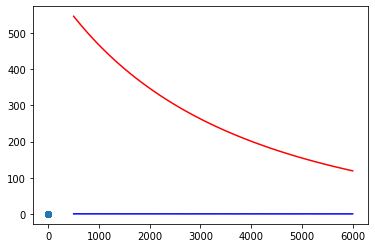

In [165]:
plt.figure()
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')

plt.scatter(x_train_low, y_train_low)

In [166]:
y_train_low

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])